In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from helper import integrate

In [36]:
def make_ring(n, r_inner=1.0, r_outer=1.2, device ="cpu"):
    theta = 2 * torch.pi * torch.rand(n, device=device)
    u = torch.rand(n, device=device)
    r = torch.sqrt((r_outer**2 - r_inner**2) * u + r_inner**2)

    x = r * torch.cos(theta)
    y = r * torch.sin(theta)

    return torch.stack([x, y], dim=1)

def make_two_gaussians(n, std: float= 0.2):
    means_lst = torch.tensor([[5., 2.], [5., -2.]])
    idxs = torch.randint(0, means_lst.size(0), (n, ))
    return torch.normal(means_lst[idxs], std)
 

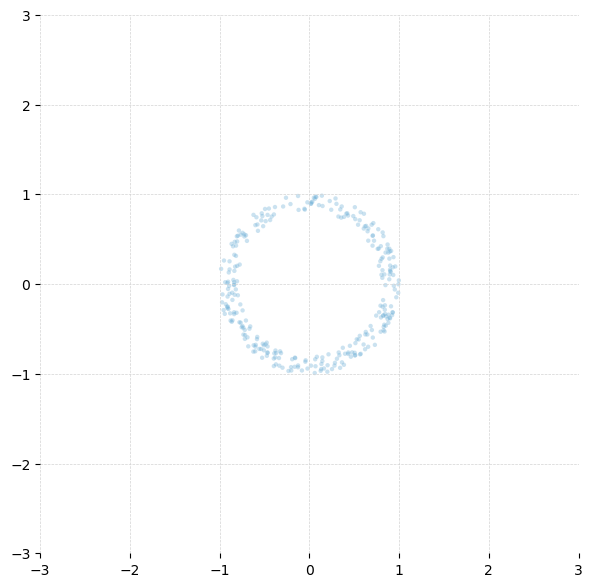

In [37]:
means_lst = torch.tensor([-2, 2])

samples0 = make_two_gaussians(300)

samples = make_ring(300, 0.8, 1.0)
x0, y0 = samples0[:, 0].numpy(), samples0[:, 1].numpy()
x, y = samples[:, 0].numpy(), samples[:, 1].numpy()

# --- Plot
fig, ax = plt.subplots(figsize=(6, 6))

scatter = ax.scatter(
    x, y,
    s=10,                # large size for bubble effect
    color="#6baed6",      # light blue
    alpha=0.35,           # semi-transparent
    edgecolor="none"
)
scatter = ax.scatter(
    x0, y0,
    s=10,                # large size for bubble effect
    color="#ff0c0c",      # light blue
    alpha=0.35,           # semi-transparent
    edgecolor="none"
)

# Optional: add subtle glow with path_effects
for col in scatter.get_facecolors():
    col[:3] *= 1.2  # brighten a bit
ax.grid(True, color='lightgray', linestyle='--', linewidth=0.5, alpha=1)

ax.set_aspect("equal")
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

# Remove axes and spines for clean look
#ax.set_xticks([])
#ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()

In [38]:
class Flow(nn.Module):
    def __init__(self, dim: int = 2, hidden: int = 64):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(dim+1, hidden), nn.ReLU(), nn.Linear(hidden, hidden), nn.ReLU(), nn.Linear(hidden, dim))
    
    def forward(self, x_t, t):
        return self.model(torch.cat([x_t, t], dim=1))

In [39]:
flow = Flow(2, 64)
optimizer = torch.optim.Adam(flow.parameters(), 1e-2)
loss_fn = nn.MSELoss()

In [40]:


for i in range(10000):
    z = make_two_gaussians(256, 0.2)
    epsilon = torch.normal(0., 0.2, (256, 2))

    t = torch.rand(size=(256, 1))
    x = z*t + (1-t)*epsilon
    u = (z-x)/(1-t)

    optimizer.zero_grad()
    loss = loss_fn(flow(x, t), u)
    loss.backward()
    optimizer.step()    
   

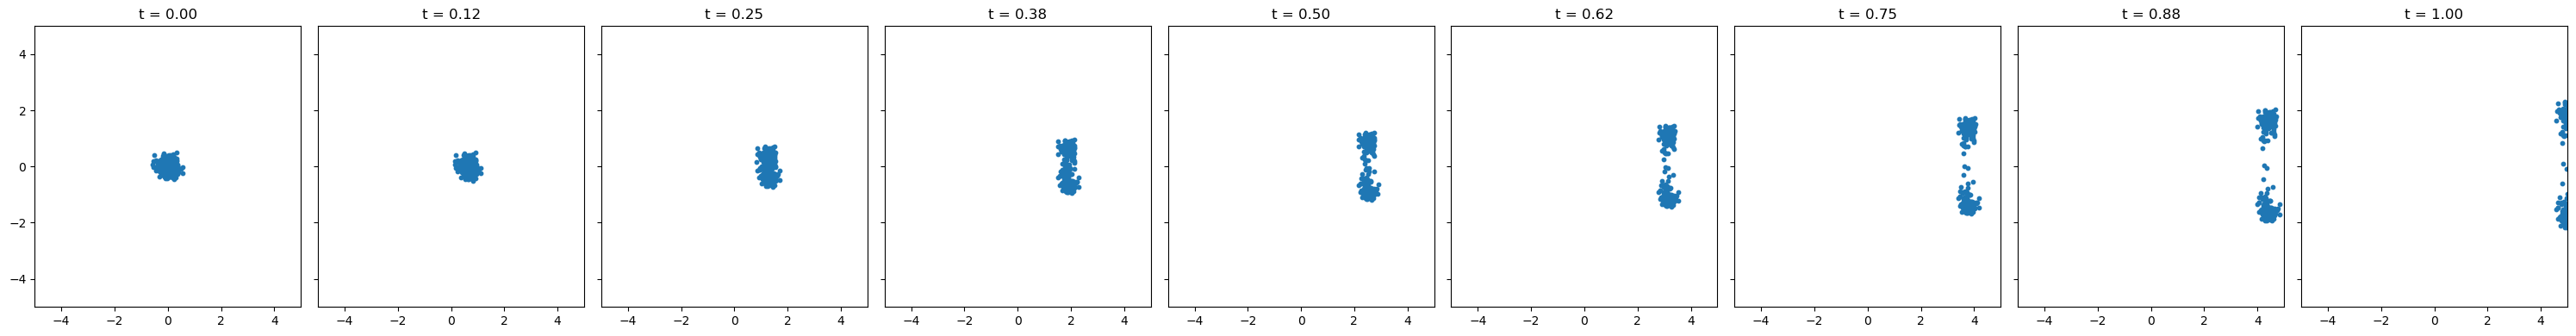

In [41]:
x = torch.normal(0., 0.2, (256, 2))
n_steps = 8
fig, axes = plt.subplots(1, n_steps + 1, figsize=(30, 4), sharex=True, sharey=True)
time_steps = torch.linspace(0, 1.0, n_steps + 1)

axes[0].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
axes[0].set_title(f't = {time_steps[0]:.2f}')
axes[0].set_xlim(-5.0, 5.0)
axes[0].set_ylim(-5.0, 5.0)

for i in range(n_steps):
    dt = time_steps[i+1]-time_steps[i]
    t_tensor = time_steps[i].expand(x.shape[0], 1)
    x = x + flow(x, t_tensor)*dt
    axes[i + 1].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
    axes[i + 1].set_title(f't = {time_steps[i + 1]:.2f}')

plt.tight_layout()
plt.show()


In [42]:
def integrate(x0, v, t=1.0, steps=100):
    dt = t/steps
    xs = [x0]
    x = x0
    for k in range(steps):
        t = torch.full((x.shape[0], 1), k * dt)
        x = x + dt * v(x, t)
        xs.append(x)
    return torch.stack(xs) 

In [43]:
def plot_flow(flow: nn.Module, samples0: torch.Tensor, use_arrows = False, draw_vector_field=False, show_time = False, xlim = [-1, 5], ylim =[-3, 3]):
    x0, y0 = x0, y0 = samples0[:, 0].numpy(), samples0[:, 1].numpy()

    samples = integrate(samples0, flow, 1.0, 1000).detach()
    
    x, y = samples[-1, :, 0].numpy(), samples[-1, :, 1].numpy()

    fig, ax = plt.subplots(figsize=(6, 6))

    scatter = ax.scatter(
        x, y,
        s=10,                # large size for bubble effect
        color="#6baed6",      # light blue
        alpha=0.9,           # semi-transparent
        edgecolor="none",
        zorder=10,
        label= "$p_1$" 
    )
    scatter = ax.scatter(
        x0, y0,
        s=10,                # large size for bubble effect
        color="#ff0c0c",      # light blue
        alpha=0.9,           # semi-transparent
        edgecolor="none",
        label="$p_0$"
    )

    # Optional: add subtle glow with path_effects
    for col in scatter.get_facecolors():
        
        col[:3] *= 1.2  # brighten a bit

    ax.grid(True, color='lightgray', linestyle='--', linewidth=0.5, alpha=1)

    ax.set_aspect("equal")
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    # Remove axes and spines for clean look
    #ax.set_xticks([])
    #ax.set_yticks([])
    
    for spine in ax.spines.values():
        spine.set_visible(False)

    for i in range(samples.shape[1]):
        ax.plot(samples[:, i, 0], samples[:, i, 1],
                color="black", alpha=0.25, linewidth=0.8)
    

    if show_time:
        for i in range(samples.shape[1]):
            plt.scatter(samples[:,i,0], samples[:,i,1],
                        c=torch.linspace(0,1,samples.shape[0]),
                        cmap="viridis", s=3)
        
    if use_arrows:     
        for i in range(samples.shape[1]):
            plt.arrow(samples[0,i,0], samples[0,i,1],
                    samples[500,i,0]-samples[0,i,0],
                    samples[500,i,1]-samples[0,i,1],
                    alpha=0.8, head_width=0.1)
    if draw_vector_field:
        
        X, Y = torch.meshgrid(
            torch.linspace(xlim[0], xlim[1], 30),
            torch.linspace(ylim[0], ylim[1], 30),
            indexing="ij"
        )

       
        pts = torch.stack([X.flatten(), Y.flatten()], dim=1)

        t = torch.full((pts.shape[0], 1), 0.5, dtype=pts.dtype)

        V = flow(pts, t)

        plt.quiver(
            pts[:, 0].numpy(), pts[:, 1].numpy(),
            V[:, 0].detach().numpy(), V[:, 1].detach().numpy(),
            alpha=0.3
        )
    plt.tight_layout()
    plt.legend()
    return fig, ax

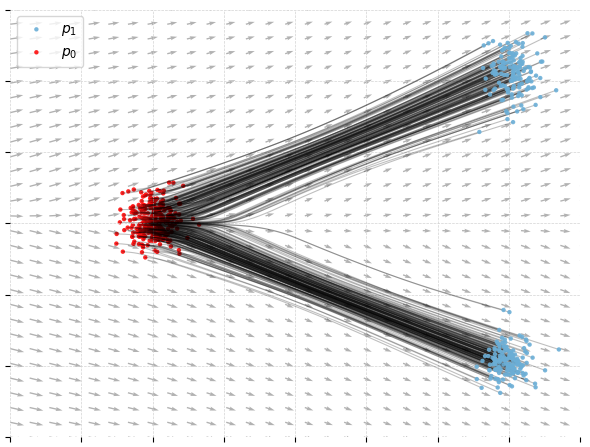

In [58]:
samples0 = torch.normal(0., 0.2, (300, 2))
fig, ax = plot_flow(flow, samples0, draw_vector_field=True, xlim=[-2, 6], ylim =[-3, 3])